# **Recuperando el coeficiente de difusión**
## **Sistemas uniradiales**

**Contexto del problema** 


**Objetivos**


**Recomendaciones**



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
from scipy.optimize import curve_fit, minimize, fmin_cg
from scipy.linalg import solve
import ipywidgets as widgets
from scipy.integrate import simps
from mpl_toolkits import mplot3d
#from ipywidgets import AppLayout, FloatSlider
#import mpl_interactions.ipyplot as iplt
#matplotlib widget
#%matplotlib ipympl
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

## Introducción 

El experimento a grandes rasgos considera la dinámica de la concentración de un sustrato en un sistema heterogéneo formado por partículas porosas y un medio líquido. Las hipótesis son las siguientes
- La geometría de la partículas es esférica
- El comportamiento de la concentración del sustrato al interior de la partículas solo depende del radio
- La difusión en el medio líquido es instantánea debido a convección mecánica 

El proceso de difusión que a nosotros nos interesa es el de efusión es decir, aquel en que la dirección de la difusión es desde el interior de la partículas hacia el seno del líquido
<div>
<p style = 'text-align:center;'>
<img src="efusion.png" alt="JuveYell" width="150px">
</p>
</div>

## Método de Grunwald

Peter Grunwald en 1989 propone un método experimental para cuantificar el coeficiente de difusión asumiendo que las particulas poseen el mismo radio. En este caso el modelo en evolución de la concentración del sustrato en el borde viene dada por 

$$\begin{align}
    \label{S_b_grun}
    S_b(t) = c_\infty + (c_0-c_\infty)\dfrac{6}{\pi}\sum_{n\in \mathbb{N}}\dfrac{1}{n^2}e^{-n^2\pi^2Dt/R^2},\quad t\geq 0
\end{align}$$

donde $c_0$ y $c_\infty$ son la concentración inicial y final en el medio, $R$ es el radio de la partículas y $D$ es el coeficiente de difusión. Las mediciones experimentales para encontrar el parámetro $D$ se realizan en el medio líquido el cual por la tercera hipótesis también será modelado por la función $S_B$. 

### Problema de optimización: Mínimos cuadrados no lineal

Sea $\{(t_i,c_i)\}_{i=1}^n$ donde $c_i$ representa la concentración medida experimentalmente en el tiempo $t_i$. Para $c_0,c_\infty,R$ fijos el ajuste para $D$ se obtiene mediante la minimización del error cuadrático experimental, es decir

$$
\begin{align}
\min_{D\in \mathbb{R}^+} J(D) := \sum_{i=1}^n |S_b(t_i)-c_i|^2
\tag{0}
\end{align}$$

lo que corresponde a un problema de minimos cuadrados no lineal.

**Datos experimentales**

Para la implementación utilizaremos la siguiente data considerada en el trabajo de C. Loyola

In [2]:
t_data = np.array([0., 0.05, 0.083, 0.167, 0.5, 1., 2.,
                   0.033, 0.067, 0.1, 0.15, 0.5, 1. ,2. ,
                   0.033, 0.05, 0.183, 0.233, 0.750, 1.25])

c_data = np.array([0., 0.433, 0.654, 0.846, 0.936, 0.984, 1.,
                  0.612, 0.795, 0.744, 0.812, 0.984, 1., 0.969,
                  0.501, 0.394, 0.893, 0.883, 0.975, 1.])

expdata = alt.Chart(pd.DataFrame({"Tiempo": t_data, "Concentración": c_data})).mark_point(opacity=0.8).encode(
    x="Tiempo",
    y="Concentración",
    tooltip=["Tiempo","Concentración"]
).properties(
    width = 900,
    height = 500,
    title = "Evolución tiempo de la concentración en el borde experimental"
).interactive()

expdata

alt.Chart(...)

donde se consideraron los siguientes parámetros

$$
\begin{align}
    c_0 = 0, \quad c_\infty = 1,\quad R= 162[\mu m]
\end{align}
$$

In [3]:
c_0=0.
c_inf=1.
R=162.  #en micrometros

**Implementación**

Para resolver el problema de optimización utilizaremos la rutina `curve_fit` disponible en `scipy.optimize`, sin embargo también debemos encontrar una aproximación numérica de la función $S_B$ ya que esta es una serie. Consideraremos la aproximación por truncación que es calculada por la siguiente función 

In [4]:
def func(t, D):
    f = np.ones(t.shape)*c_inf
    for i in range(1,n+1):
        f += (c_0-c_inf)*(6/(np.pi**2))*(1/i**2)*np.exp(-(i**2)*np.pi**2*D*t/(R**2)) 
    return f

*Observación de la implementación:* Notemos que esta función depende de la variable global `n` debido a la sintaxis de las rutinas que utilizaremos

y usaremos la siguiente función para calcular el error

In [5]:
def errM2(f,g):
    return ((f-g)**2).sum()

**Aproximación de la serie al primer término**

*Observación de la implementación* En este caso se prefiere utilizar `altair` para la visualización pues ofrece herramientas de más facil acceso para colocar legendas interactivas a la data en la variable `tooltip`

In [6]:
#Definición de la variable global n
n=1

#Resolución del problema de mínimos cuadrados no lineal
popt, pcov = curve_fit(func, t_data, c_data,bounds = (1,np.inf))

#Definición de la malla para la visualización de la función ajustada
t = np.arange(-0.1,2.1,0.01)

#Scatter plot con error puntual
experr = alt.Chart(pd.DataFrame({"Tiempo": t_data, "Concentración": c_data, "Error cuadrático" : (func(t_data, popt[0]) - c_data)**2})).mark_point(opacity = 0.8).encode(
    x="Tiempo",
    y="Concentración",
    tooltip=["Tiempo","Concentración", "Error cuadrático:Q"],
).properties(
    width = 900,
    height = 500,
    title = "Evolución tiempo de la concentración con ajuste al primer término"
).interactive()

#SB con el ajuste realizado
ajuste = alt.Chart(pd.DataFrame({"Tiempo": t, "Concentración": func(t, popt[0])})).mark_line(color = "red").encode(
    x="Tiempo",
    y="Concentración",
).interactive()

print(f"El error total del ajuste es {errM2(func(t_data, popt[0]), c_data)}")

#Unión de gráficos
experr + ajuste

El error total del ajuste es 0.2543663747655845


alt.LayerChart(...)

Con `matplotlib.pyplot` la implementación sería la siguiente

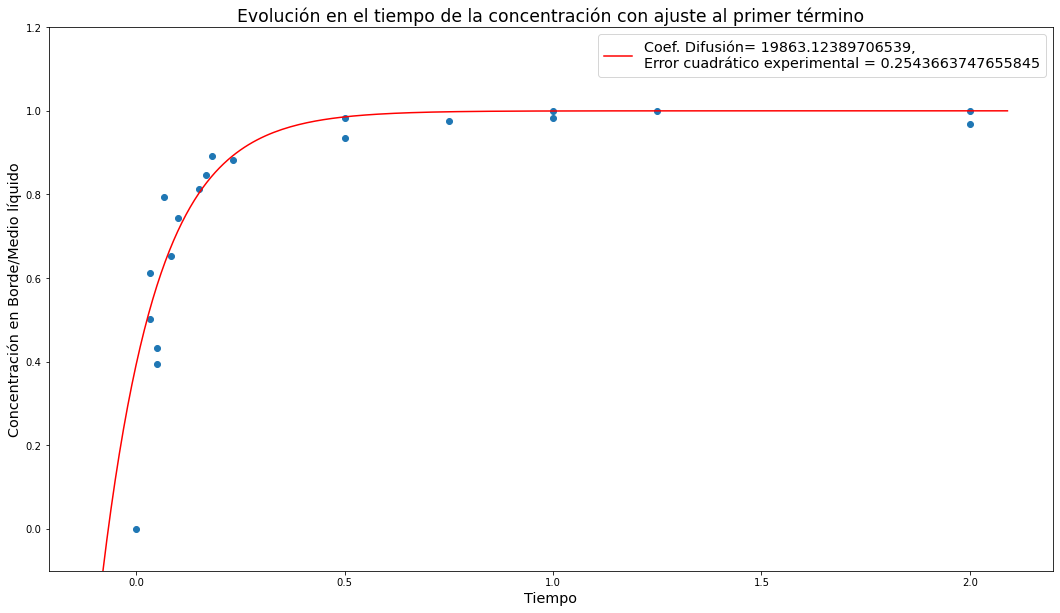

In [7]:
fig = plt.figure(figsize = (18,10))
plt.plot(t, func(t, popt[0]), 'r-', label = f"Coef. Difusión= {popt[0]},\nError cuadrático experimental = {errM2(func(t_data, popt[0]), c_data)}",)

plt.scatter(t_data, c_data)# 'b-', label='data')
plt.ylim(-0.1, 1.2)
plt.xlabel('Tiempo', fontsize = "x-large")
plt.ylabel('Concentración en Borde/Medio líquido', fontsize = "x-large")
plt.title("Evolución en el tiempo de la concentración con ajuste al primer término", fontsize= "xx-large")
plt.legend(fontsize='x-large')
plt.show()
#fig.canvas.header_visible = False


A pesar de que esta visualización es más tosca y contiene menos información nos permitirá agregando algunas pocas lineas comparar una gran cantidad de casos para distintos ordenes de aproximación.

**Aproximaciones de orden superior**

Ajustaremos $D$ considerando aproximaciones de truncación entre el orden 1 y 100. Para esto
1. Resolvermos el problema para cada caso y guardaremos la información en el arreglo `op_ar`

In [8]:
n_max = 100 

# Arreglo para guardar la información
op_ar = np.zeros((n_max,2))

for i in range(0,n_max):
    n = i
    popt, pcov = curve_fit(func, t_data, c_data, bounds = (1,np.inf))
    op_ar[i,0] = popt[0]
    op_ar[i,1] = errM2(func(t_data, popt[0]), c_data)

2. Definiremos una función auxiliar para graficar

In [9]:
def func1(t, D, n, R, c_0, c_inf):#, c_0=0, c_inf=1, R=162*10**(-6), n=3):
    f = np.ones(t.shape)*c_inf
    for i in range(1,int(n)+1):
        f += (c_0-c_inf)*(6/(np.pi**2))*(1/i**2)*np.exp(-(i**2)*np.pi**2*D*t/(R**2)) 
        #print(f)
    return f

3. Generaremos la visualización interactiva
*Observación de la implementación:* Solo animaremos hasta el paso 29 pues los valores más altos tienen problemas para interpretar los otros números. Además se redefinen las variables $c_0, c_\infty, R$ para no tener problemas al recargar la visualización 

In [10]:
#A pesar

nmax = 29

def g(n):
    c_0=0.
    c_inf=1.
    R=162.
    t = np.arange(-0.1,2.1,0.01)
    plt.figure(figsize=(18,10))
    plt.plot(t, func1(t, op_ar[n,0], n, R, c_0, c_inf), 'r-')
    plt.legend([f"Coef. Difusión= {op_ar[n,0]},\nError cuadrático experimental = {op_ar[n,1]}"],fontsize = "x-large")
    plt.scatter(t_data, c_data)
    plt.ylabel('Concentración en Borde/Medio líquido', fontsize = "x-large")
    plt.title(f"Evolución tiempo de la concentración con ajuste al término {n}", fontsize= "xx-large")
    plt.ylim(-0.1, 1.2)
    plt.xlabel('Tiempo', fontsize = "x-large")

interactive_plot = interactive(g, n = (0,nmax,1))#, b=(-3, 3, 0.5))

interactive_plot

interactive(children=(IntSlider(value=14, description='n', max=29), Output()), _dom_classes=('widget-interact'…

Se puede observar que
1. El coeficiente de difusión aproximado se mantiene constante para los primeras 17 cifras significativas a partir del paso 17
2. Desde la aproximación al término 15 el error tiene una disminución de orden menor a $10^{-3}$

## Ecuación de difusión

### Motivación ### 

Bajo las supociones del método de Grunwald el comportamiento de la concentración $S$ de un sustrato dado se puede modelar via la EDP

$$\begin{align}
        \label{edplin} 
        \left\{
        \begin{array}{rcll}
            \partial_tS=D\left(\partial_{rr}^2S+\dfrac{2}{r}\partial_rS\right)  &\textrm{ en }&(0, T)\times (0, R)\\
            S(t, R)=S_b(t),\ \partial_rS(t, 0)=0 &\textrm{en}& (0, T)\\
            S(0, r)=S_0(r)  &\textrm{en}& (0, R).
        \end{array}
        \right.
        \tag{1}
    \end{align}$$

donde $S_0$ es la concentración radial inicial.
> **Interpretación física** 
> 1. La Ley de Fick asegura que la difusión se puede modelar por $S_t = D \Delta S$ lo que coincide para concentraciones radiales al realizar un cambio de variables a coordenadas esféricas,
> 2. $S(t,R)$ es el comportamiento temporal de la concentración en el borde,
> 3. $S_r(t,0)=0$ nos dice que no existe flujo de sustrato en el centro de la esfera.

Notemos que el funcional $J$ del método de Grunwald puede ser reinterpretado de manera continua para así obtener

$$ \begin{align}
    \label{min}
    \tag{2}
    \min_{D\in \mathbb{R}^+} \int_0^T|S_b(t)-g(t)|^2dt
\end{align}
$$

donde $g$ representa la información experimental. 

### Modelo a estudiar ###

Notemos que la EDP presentada en (1) tiene como parámetro la función $S_b$ por lo que conocer su solución no aportará información a la resolución del problema de minimización (2). En vista de esto tendremos que asumir a $S_b$ una función desconocida por lo que acoplaremos su dinámica al comportamiento de la concentración $S$ al intererior de la partícula para esto utilizaremos la ecuación de continuidad de la masa. Para aterrizar esta idea nos serán de utilidad los siguientes parámetros

$$\begin{align}
    &V_b: \text{ Volumen del medio líquido}\\
    &V_c: \text{ Volumen del conjunto de partículas}
\end{align}$$

**Continuidad de la masa**

La ecuación de continuidad de la masa que se transporta entre los inmobilizadores y el medio líquido está dada por

$$\begin{align}
 \dfrac{dm}{dt} + \iint_V j d\sigma = M
\end{align}
$$

donde $m$ representa la masa, $j$ su flujo, $V$ la superficie en estudio y $M$ el cambio de la masa que entra o sale del sistema. En nuestro caso 

1. $m(t,R) = V_bS_b(t)$
2. $j(t,R) = D\partial_n S(t,\sigma) = D\partial_r S(t,R)$ donde $S$ es la concentración del sustrato en cada inmobilizador 
3. $V$ es la unión de las superficies de cada inmobilizador
4. $M = 0$

Si asumimos que existen $n$ inmobilizadores como son todos de igual radio es válido 

$$ \begin{align}
    \iint_V j(t) d\sigma = 4\pi R^2 n D\partial_r S(t,R)
\end{align}
$$

además 


$$ \begin{align}
    n = \dfrac{3V_c}{4\pi R^3}
\end{align}
$$

entonces


$$ \begin{align}
     \dfrac{dm}{dt} + \dfrac{3 D V_c}{R} \partial_r S(t,R) = 0
\end{align}
$$

por lo que si hacemos $c = \dfrac{3 D V_c}{R V_b}$ y dividimos la ecuación anterior por $V_b$ obtenemos

$$ \begin{align}
    \tag{3}
     S_b'(t) = -c\partial_r S(t,R)
\end{align}
$$

**Sistema acoplado**

Al reemplazar la condición $S(t,R) = S_b(t)$ por (3) en el sistema (1) y agregando su respectiva condición inicial obtenemos

$$\begin{align}
    \label{edpedolin} 
    \left\{
    \begin{array}{lcll}
        \partial_tS=D\left(\partial_{rr}^2S-\dfrac{2}{r}\partial_rS\right)  &\textrm{ en }&(0, T)\times (0, R)\\
        \partial_rS(t, 0)=0 &\textrm{en}& (0, T)\\
        S_B'(t)=-c\partial_r S(t,R) &\textrm{en}& (0, T)\\
        S(0, r)= S_0(r) &\textrm{en}& (0, R)\\
        S_b(0) = S_{b0},
    \end{array}
    \right.
    \tag{4}
\end{align}$$

*Observación:* A pesar de sacar la condición $S(t,R) = S_b(t)$ del sistema esta no se deja de cumplir, recordemos que necesariamente la concentración en el medio líquido debe ser la misma que en el borde de cada inmobilizador.

En [GMV2019](https://doi.org/10.1002/mma.5637) se estudia una configuración particular para el operador espacial asociado a esta ecuación y se concluye que 

1. Es un operador monótono maximal, 
2. Es autoadjunto 

de esta manera utilizando el Teorema de Hille - Yosida, se afirma de que $A$ es un generador de un semigrupo contractivo y por tanto el problema de Cauchy abstracto (en nuestro caso un problema de valor inicial y frontera) está bien puesto con soluciones

$$\begin{align}
    S_b \in C([0,T))\cap C^1(0,T),\quad S\in C([0,T),L^2(0,R))\cap C^1((0,T);H^2(0,R))
\end{align}
$$

para valores iniciales $(S_{b0}, S_0)\in \mathbb{R} \times H^2(0,R)$.

*Observación:* Para resultados sobre operadores monótonos maximales con aplicación a EDP se recomienda consultar [CH1999](https://global.oup.com/academic/product/an-introduction-to-semilinear-evolution-equations-9780198502777?cc=cl&lang=en&) y [AP1983](https://doi.org/10.1007/978-1-4612-5561-1)

**Solución numérica**

Siguiendo lo propuesto en [GMV2019](https://doi.org/10.1002/mma.5637) y [VFWI2010](10.1016/j.bej.2010.01.002) utilizaremos diferencias finitas para aproximar numericamente la solución de nuestro problema. El esquema seguirá 

1. Para el interior: El método de Crank-Nicholson con diferencias centradas para el espacio
2. Para $r=0$: Aproximaciones adelantadas de segundo orden adelantadas
3. Para $r=R$: El método de Crank-Nicholson con diferencias atrasadas de segundo orden en el espacio 

además será conveniente escribir (4) como

$$\begin{align}
    \label{edpedolindes} 
    \left\{
    \begin{array}{lcll}
        \partial_tS=D\left(\partial_{rr}^2S-\dfrac{2}{r}\partial_rS\right)  &\textrm{ en }&(0, T)\times (0, R)\\
        S_b(t) = S_r(t,R) & \textrm{ en }&(0, T)\\
        \partial_rS(t, 0)=0 &\textrm{en}& (0, T)\\
        \partial_tS(t,R)=-cS_r(t,R) &\textrm{en}& (0, T)\\
        S(0, r)= S_0(r) &\textrm{en}& (0, R)\\
        S(0,R) = S_{b0}.
    \end{array}
    \right.
    \tag{5}
\end{align}$$

Por simplicidad consideraremos mallas con pasos uniformes tanto en tiempo como espacio la cual notaremos por

$$
\begin{align}
    (ndt,idx)_{n,i=0}^{n=nt-1, i=nx-1}
\end{align}
$$

donde $dt$ y $dx$ repesentan el paso temporal y espacial respectivamente mientras que $nt$ y $nx$ repesentan la cantidad de nodos temporales y espaciales respectivamente. Notemos que para estos valores existe la siguiente relación

$$
\begin{align}
    T = dt(nt-1), \quad R = dx(nx-1)  
\end{align}
$$

Con todo esto si $S^n_i:=S(ndt,idx)$ entonces
1. Para $i=0$ la aproximación de segundo orden viene dada por 
$$\begin{align}
    -\dfrac{3}{2}S_0^{n+1}+2S_1^{n+1}-\dfrac{1}{2}S_2^{n+1}=0
\end{align}$$

2. Para $i=1,...,nx-2$
$$\begin{align}
    \dfrac{S_i^{n+1}-S_i^{n}}{dt} = D\dfrac{1}{2}\left( \dfrac{S_{i-1}^n - 2S_{i}^n + S_{i+1}^n}{dx^2} + \dfrac{1}{idx}\dfrac{S_{i+1}^n-S_{i-1}^n}{dx} + \dfrac{S_{i-1}^{n+1} - 2S_{i}^{n+1} + S_{i+1}^{n+1}}{dx^2} + \dfrac{1}{idx}\dfrac{S_{i+1}^{n+1}-S_{i-1}^{n+1}}{dx} \right) 
\end{align}$$
o equivalentemente 
$$\begin{align}
    S_i^{n+1} &- \dfrac{Ddt}{2dx^2}\left(\left[1-\dfrac{1}{i}\right]S_{i-1}^{n+1} - 2S_{i}^{n+1} + \left[1+\dfrac{1}{i}\right]S_{i+1}^{n+1} \right)\\
    &= S_i^{n} + \dfrac{Ddt}{2dx^2}\left(\left[1-\dfrac{1}{i}\right]S_{i-1}^{n} - 2S_{i}^{n} + \left[1+\dfrac{1}{i}\right]S_{i+1}^{n} \right)
\end{align}$$

3. Para $i=nx-1$
$$\begin{align}
    \dfrac{S_{nx-1}^{n+1}-S_{nx-1}^{n}}{dt} = -c\dfrac{1}{2}\left(\dfrac{\frac{1}{2}S_{nx-3}^{n+1}-2S_{nx-2}^{n+1}+\frac{3}{2}S_{nx-1}^{n+1}}{dx} + \dfrac{\frac{1}{2}S_{nx-3}^{n}-2S_{nx-2}^n+\frac{3}{2}S_{nx-1}^{n}}{dx} \right)
\end{align}$$
o equivalentemente
$$\begin{align}
    S_{nx-1}^{n+1} &+c\dfrac{dt}{2dx}\left(\frac{1}{2}S_{nx-3}^{n+1}-2S_{nx-2}^{n+1}+\frac{3}{2}S_{nx-1}^{n+1}  \right)\\
    &= S_{nx-1}^{n}- c\dfrac{dt}{2dx}\left(\frac{1}{2}S_{nx-3}^{n}-2S_{nx-2}^n+\frac{3}{2}S_{nx-1}^{n}\right)
\end{align}$$

Lo anterior puede ser interpretado como un sistema de ecuaciones con incognitas $S_i^{n+1}$, por lo tanto lo podemos escribir de manera matricial como

$$AS^{n+1} = BS^{n} \tag{6}$$

para determinadas matrices $A$, $B$ de tamaño $nx\times nx$ y $S^{n} = \left(S_i^n\right)_{i=0}^{nx-1}$.

### Implementación

Tomando

$$\sigma_1 = \dfrac{dt}{2dx^2},\quad \sigma_2 = \dfrac{dt}{2dx}$$

las matrices $A$ y $B$ se generarán con las siguientes funciones

In [11]:
def m_unif_A(nx, sigma1, sigma2, D, c):
    A = np.zeros((nx,nx))
    
    #Primera fila i=0
    A[0,0] = -3./2.
    A[0,1] = 2
    A[0,2] = -1./2
    
    #Filas i=1,...,nx-2
    for j in range(1,nx-1):
        A[j,j-1] = - (D*sigma1)*(1-1./j)
        A[j,j] = 1 + 2*D*sigma1
        A[j,j+1] =  -(D*sigma1)*(1+1./j)
    
    #Fila i = nx-1
    A[nx-1,nx-3] = c*sigma2/2.
    A[nx-1,nx-2] = -2*c*sigma2
    A[nx-1,nx-1] = 1+3*c*sigma2/2.
    return A  

def m_unif_B(nx,sigma1,sigma2,D,c):
    B= np.zeros((nx,nx))
    
    #Filas j=1,...,nx-1
    for j in range(1,nx-1):
        B[j,j-1] = (D*sigma1)*(1-1./j)
        B[j,j] = 1 - 2*D*sigma1
        B[j,j+1] =  (D*sigma1)*(1+1./j)
    
    #Fila i = nx-1
    B[nx-1,nx-3] = -c*sigma2/2.
    B[nx-1,nx-2] = 2*c*sigma2
    B[nx-1,nx-1] = 1-3*c*sigma2/2.
    return B

mientras que 

In [12]:
def CN_2OR(S, nx, nt, Vc, Vb, R, D,T):
     
    #Constantes utilizadas 
    dx = R/(nx-1)
    dt = T/(nt-1) 
    sigma1 = dt/(2.*dx**2)
    sigma2 = dt/(2.*dx)
    c = 3*Vc/(R*Vb)*D
    
    #Construcción de las matrices
    A = m_unif_A(nx, sigma1, sigma2, D, c)
    B = m_unif_B(nx,sigma1,sigma2,D,c)
    
    #Creación de arreglos para guardar la información
    Sb = np.zeros(nt)
    SA = np.zeros(nt,object)
    
    #Iteración temporal 
    for t in range(nt):
        
        #Se guarda la información
        SA[t] = np.array(S)
        Sb[t] = S[-1]   
        
        #Se calcula el lado derecho de (6)
        b = B.dot(S) 
        
        #Se encuentra el vector S^{n+1}
        S = solve(A,b)
        
    return S, Sb, SA

será la función para encontrar la solución numérica. 

**Ejemplo**

Consideremos

$$ T = 500[s],\quad D = 10^{-10}[m^2/s],\quad R= 10^{-4}[m],\quad V_b = 400[ml],\quad V_c = 0.01, $$

$$ S_0(r) = 4,\quad S_{b0} = 0, $$

$$ nx = 400,\quad nt = 4000 $$

In [13]:
#Parámetros de la ecuación 

#Dominio temporal
T = 500
#Coef. difusión efectiva [m^2/s]
D = 10**(-10.)

#Radio de las partículas [m]
R1 = 10**(-4.)

#Otros parámetros [ml]
Vb = 400 
Vc = 0.01 

#Número de nodos
nt = 4000
nx = 400

#Cond. Inicial
Sb0 = 0
Sin = np.ones(nx)*4
Sin[-1] = Sb0
S = Sin.copy()

Luego la resolución del problema la podemos obtener mediante

In [14]:
S, Sb, SA = CN_2OR(S, nx, nt, Vc, Vb, R1, D, T)

 
**Visulización de resultados**

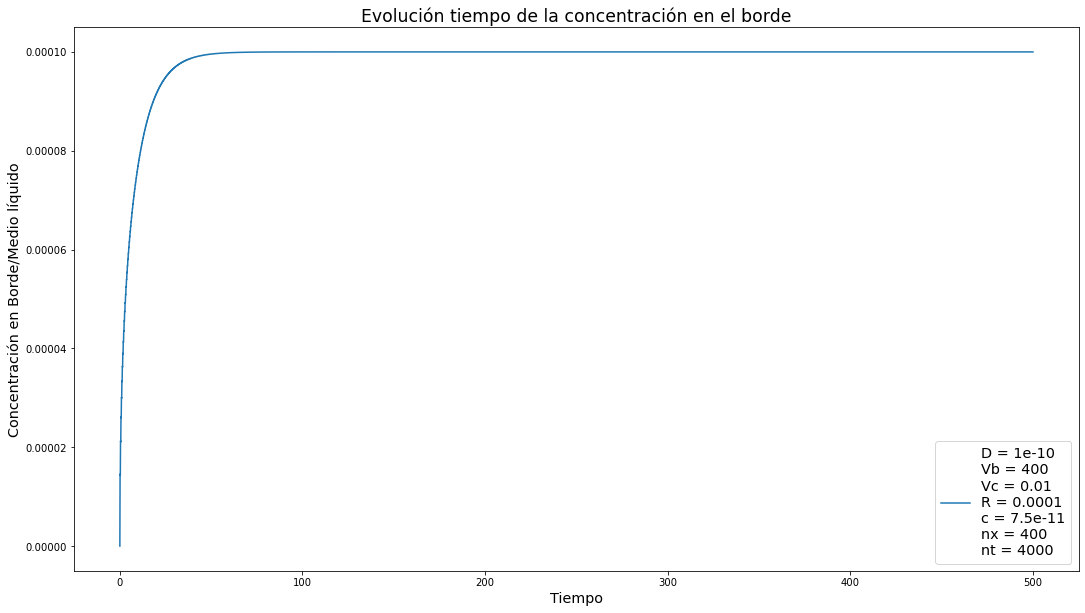

In [15]:
c = 3*Vc/(R1*Vb)*D

fig2 = plt.figure(figsize=(18,10))
plt.plot(np.linspace(0, T, nt), Sb)

plt.title("Evolución tiempo de la concentración en el borde", fontsize= "xx-large")
plt.legend([f"D = {10**(-10)}\nVb = {Vb}\nVc = {Vc}\nR = {R1}\nc = {c}\nnx = {nx}\nnt = {nt}"], fontsize = "x-large")

plt.xlabel('Tiempo', fontsize = "x-large")
plt.ylabel('Concentración en Borde/Medio líquido', fontsize = "x-large")

plt.show()

In [16]:
# Parámetro para ajustar el tiempo máximo de visualización
ntmax = 400
dt = T/(nt-1) 

def h(T):
    x = np.linspace(0, R1, nx)
    
    plt.figure(figsize=(18,10))
    plt.plot(x,SA[T], 'r-')
    
    plt.title(f"Concentración interior en T = {T*dt}[s]", fontsize= "xx-large")
    
    plt.legend([f"D = {10**(-10)}\nVb = {Vb}\nVc = {Vc}\nR = {R1}\nc = {c}\nnx = {nx}\nnt = {nt}"], fontsize = "x-large")
    
    plt.ylim(-0.1, 4.1)
    
    plt.xlabel('Interior del inmobilizador', fontsize = "x-large")
    plt.ylabel("Concentración en el interior", fontsize = "x-large")
    
iplot1 = interactive(h, T = (0,ntmax,1))
iplot1

interactive(children=(IntSlider(value=200, description='T', max=400), Output()), _dom_classes=('widget-interac…

## Comparación con el modelo de Grunwald ##

El objetivo de esta sección es comparar cualitativamente el modelo propuesto por Grunwald y el comportamiento obtenido mediante la resolución numérica de (4). Para esto generaremos visualizaciones interactivas que nos permitan observar el comportamiento para cambios en el coeficiente de difusión $D$ y el radio de los inmobilizadoes $R$.

*Observación de la implementación: Debido a que hay que resolver numericamente la EDP gran cantidad de veces se opto por implementar funciones que permitan guardar la información de los arreglos obtenidos en archivos `.txt`. Se comentará adecuadamente el código para quienes quieran generar su propio archivo con los datos obtenidos de los experimentos numéricos. 

### Cambio en el coeficiente de difusión ###

Lo primero es presentar la función que nos permitirá guardar la información de las simulaciones

In [17]:
def funcauxD(Sin, T, nx, nt, Vc, Vb, R, Dit, name): #En este caso el parámetro Dit será una lista de los coeficienties que se quieren comparar
    
    #Se genera un areglo de objetos que corresponderas a arreglos de 2 dimensiones
    SAD = np.zeros(Dit.size,object)
    
    #Se resulve la EDP para cada D
    for dn in range(Dit.size):
        SAD[dn]= np.stack(CN_2OR(Sin, nx, nt, Vc, Vb, R, Dit[dn],T)[2], axis=0)
    
    #Se convierte SAD a un np arreglo de 3 dimensiones
    SAD = np.stack(SAD) 
    
    #Se convierte SAD a un arreglo de 2 dimensiones
    #Esto es necesario por como funciona el comando save.txt
    SAD_reshaped = SAD.reshape(SAD.shape[0], -1) 
    
    i=0
    for namei in np.vsplit(SAD_reshaped,SAD_reshaped.shape[0]):
        path = "Data/" + name.split(".")[0] + str(i) + ".txt"  
        np.savetxt(path, namei)
        i += 1
    #Se guarda la información
    #np.savetxt("Nombre.txt", SAD_reshaped) 
    return SAD

#Si se descomenta la siguiente linea se llamará a la función
#exp1 = funcauxD(Sin1, T4, nx4, nt4, Vc, Vb, R1, Dit4, "CompD1.txt")

In [79]:
def loadsplitdata(data, malla):
    arr = np.zeros(malla.shape[0], object)
    for i in range(malla.shape[0]):
        path = "Data/" + data.split(".")[0] + str(i) + ".txt"
        arr[i] = np.loadtxt(path)
    return np.stack(arr)

Lo que veremos corresponde a las similuaciones realizadas con los parámetros
$$\begin{equation}
    V_c = 0.01, \quad V_b = 400, \quad R= 10^{-4}, \quad T = 1000\\
    nt = 3000, \quad nx = 400\\
    S_0(r) = 1,\quad S_{b0}= 0
\end{equation}
$$

y $D$ recorrera una malla equiespaciada de 25 puntos entre $0.5D_1$ y $5D_1$ con $D_1=10^{-9}$ . Ahora definimos los datos, cargamos el archivo y lo volvemos un arreglo de 3 dimensiones.

In [81]:
T4 = 1000
nt4 = 3000
nx4 = 300
Dit4=np.linspace(0.5*D,D*5,25)
CompDaux = loadsplitdata("CompD1.txt",Dit4) 
CompD1 = CompDaux.reshape((Dit4.shape[0], nt4, nx4)) 

generamos la visualización

In [82]:
def Y4(d,Tn):
    c_0 = 0
    c_inf= Vc/(Vb+Vc)
    t = np.linspace(0,T4,nt4)
    x = np.linspace(0, R1, nx4)
    dt = T4/(nt4-1)
    fgrun = func1(t, Dit4[d], 16, R1, c_0, c_inf)
    
    plt.figure(figsize = (20,10))
    plt.subplot(2, 1, 1)
    
    plt.plot(x,CompD1[d,Tn,:], 'r-')
    
    plt.title(f"Concentración interior en T = {Tn*dt}[s]", fontsize= "xx-large")
    plt.legend([f"D = {Dit4[d]: e}\nVb = {Vb}\nVc = {Vc}\nR = {R1}\nc = {c}\nnx = {nx4}\nnt = {nt4}"], fontsize = "x-large")
    plt.ylim(-0.1, 1.1)
    plt.xlabel('Interior del inmobilizador', fontsize = "x-large")
    plt.ylabel("Concentración en el interior", fontsize = "x-large")
    
    plt.subplot(2,1,2)
    plt.plot(t, CompD1[d,:,-1],"r-")
    plt.scatter(t[Tn], fgrun[Tn])
    plt.plot(t, fgrun,"g--")
    
    plt.legend([f"Coef. Difusión= {Dit4[d]: e}"],fontsize = "x-large")
    plt.ylabel('Concentración en Borde/Medio líquido', fontsize = "x-large")
    plt.xlabel('Tiempo', fontsize = "x-large")
    plt.title(f"Comparación", fontsize= "xx-large") 
    plt.xlim(-10,501)
    plt.show()

iplot2_1 = interactive(Y4, d=(0,Dit4.shape[0]-1,1), Tn=(0,499,1))
iplot2_1

interactive(children=(IntSlider(value=12, description='d', max=24), IntSlider(value=249, description='Tn', max…

*Observación:* Se grafica solo hasta el tiempo 500, debido a que el comportamiento para tiempos más altos no agrega información para determinar el comportamiento cualitativo

### Cambio en el Radio del inmobilizador ###

Lo primero es presentar la función que nos permitirá guardar la información de las simulaciones la cual tiene la misma estructura que la de la sección anterior

In [20]:
def funcauxR(Sin, T, nx, nt, Vc, Vb, Rit, Da, name): #En este caso el parámetro D será una lista de los coeficienties que se quieren comparar
    SAD = np.zeros(Rit.size,object)
    for rn in range(Rit.size):
        SAD[rn]= np.stack(CN_2OR(Sin, nx, nt, Vc, Vb, Rit[rn], D,T)[2], axis=0)
    SAD = np.stack(SAD) 
    SAD_reshaped = SAD.reshape(SAD.shape[0], -1) 
    i=0
    for namei in np.vsplit(SAD_reshaped,SAD_reshaped.shape[0]):
        path = "Data/" + name.split(".")[0] + str(i) + ".txt"  
        np.savetxt(path, namei)
        i += 1 
    return SAD

#exp1 = funcauxR(Sin1, TR, nxR, ntR, Vc, Vb, Rit, D, "CompR1.txt")


Lo que veremos corresponde a las similuaciones realizadas con los parámetros
$$\begin{equation}
    V_c = 0.01, \quad V_b = 400, \quad D= 10^{-10}, \quad T = 1500\\
    nt = 2000, \quad nx = 100\\
    S_0(r)=1,\quad S_{b0}=0
\end{equation}
$$

y $R$ recorrera una malla equiespaciada de 25 puntos entre $0.5R_1$ y $5R_1$ con $R_1=10^{-4}$. Ahora definimos los datos, cargamos el archivo y lo volvemos un arreglo de 3 dimensiones.


In [83]:
T2 = 1500
nt2 = 2000
nx2 = 100
Rit=np.linspace(0.5*R1,R1*5,25)
Sin1 = np.ones(nx2)
Sin1[-1] = Sb0
CompRaux = loadsplitdata("CompR1.txt",Rit) 
CompR = CompRaux.reshape((Rit.shape[0], nt2, nx2)) 

In [84]:
def YR(r,Tn):
    c_0 = 0
    c_inf= Vc/(Vb+Vc)
    t = np.linspace(0,T2,nt2)
    x = np.linspace(0, Rit[r], nx2)
    fgrun = func1(t, D, 16, Rit[r], c_0, c_inf)
    
    plt.figure(figsize = (20,10))
    plt.subplot(2, 1, 1)
    
    plt.plot(x,CompR[r,Tn,:], 'r-')
    
    plt.title(f"Concentración interior en T = {Tn*dt}[s]", fontsize= "xx-large")
    
    plt.legend([f"D = {D:e}\nVb = {Vb}\nVc = {Vc}\nR = {Rit[r]:e}\nc = {c}\nnx = {nx2}\nnt = {nt2}"], fontsize = "x-large")
    
    plt.ylim(-0.1, 1.1)
    
    plt.xlabel('Interior del inmobilizador', fontsize = "x-large")
    plt.ylabel("Concentración en el interior", fontsize = "x-large")
    
    plt.subplot(2,1,2)
    plt.plot(t, CompR[r,:,-1],"r-")
    plt.legend([f"R = {Rit[r]:e}"],fontsize = "x-large")
    plt.scatter(t[Tn], fgrun[Tn])
    plt.plot(t, fgrun,"g--")
    plt.ylabel('Concentración en Borde/Medio líquido', fontsize = "x-large")
    plt.title(f"Comparación ykpz", fontsize= "xx-large")
    plt.xlabel('Tiempo', fontsize = "x-large")
    plt.show()

iplot3_1 = interactive(YR, r=(0,Rit.shape[0]-1,1), Tn=(0,nt2-1,1))
iplot3_1

interactive(children=(IntSlider(value=12, description='r', max=24), IntSlider(value=999, description='Tn', max…

### Resultados: Comentarios y problemas ###

Se observa que 
1. El modelo propuesto por Grunwald presenta el mismo comportamiento que la solución numérica obtenida del sistema (4)
2. La variación del radio afecta significativamente el comportamiento de la concentración en el medio líquido 

de donde se desprenden los problemas

**Problema 1**: Comprobar "analíticamente" que la dinámica de la concentración en el borde viene modelada por la función propuesta por Grunwald.
> *Propuesta de como atacar el problema:*
> Según lo revisado se sugiere analizar el problema de Strum-Liuville asociado a (1) el cual está desarrollado en el trabajo de C. Loyola. Como se comentó la solución obtenida de tal modelo depende del comportamiento del sustrato en el borde y por tanto estára en función de esta, si tal solución cumple la condición de borde obtenida desde la ecuación de continuidad de la masa y la condición inicial del compotamiento del medio líquido se espera que también sea solución del problema (4). Se debe poner atención entre la equivalencia de los parámetros $c_0$ y $c_\infty$ con $S_{b0}$, $S_0(r)$, $V_c$ y $V_b$, la cual viene dada por
>$$\begin{align}
    c_0 = S_{b0},\quad c_\infty = \dfrac{S_{b0} V_b + n\int_{B_R}S_0dV}{V_c+V_b}
\end{align}
$$
donde $B_R$ es la bola de radio $R$ centrada en $0$ y $n= \frac{3V_c}{4\pi R^3}$.

**Problema 2**: Realizar un análisis de sensibilidad para los paráme.tros $R$ y $D$ del modelo. Estudiar si es posible ajustar los parámetros $D$ y $R$ simultaneamete. Este problema será tratado en la siguiente sección.



## Análisis de sensibilidad

Debido a que no detectamos grandes diferencias entre el modelo de Grunwald y la solución numérica de (4) todo el análisis lo haremos obteniendo información de las funciones implementadas en la sección *Método de Grunwald*. Lo que haremos será lo siguiente

1. Estableceremos un punto de comparación, es decir guardaremos la información para parámetros fijos (es el caso equivalente a la primera resolución de (4))

$$\begin{equation}
    V_c = 0.01, \quad V_b = 400, \quad T = 500\\
    c_0 = 0,\quad c_\infty = \dfrac{V_c}{V_b+V_c}\\
    \quad D= 10^{-10}, \quad R = 10^{-4}
\end{equation}
$$

In [ ]:
tgrid = np.linspace(0,T,1000)
fgrun_comp = func1(tgrid, D, 16, R1, 0, Vc/(Vb+Vc))

2. Generaremos un malla para D y R

In [ ]:
Dit3 = np.linspace(0.1*D,10*D,100)
Rit3 = np.linspace(0.1*R1,10*R1,100)

3. Para la malla sobre D calculamos los errores (funcionales de minimización) definidos en (2) y (1). Lo mismo para $R$

In [ ]:
def funcauxD1(t, n, Dit, R, c_0, c_inf, f):
    F = np.zeros(Dit.size,object)
    for dn in range(Dit.size):
        g = func1(t, Dit[dn], n, R, c_0, c_inf)
        errcont = simps((g-f)**2,t)
        errdis = ((g-f)**2).sum()
        F[dn]= np.array([errcont,errdis])
    F = np.stack(F) 
    #F_reshaped = F.reshape(F.shape[0], -1) 
    np.savetxt("SenD.txt", F) 
    return F
def funcauxR1(t, n, D, Rit, c_0, c_inf, f):
    F = np.zeros(Rit.size,object)
    for rn in range(Rit.size):
        g = func1(t, D, n, Rit[rn], c_0, c_inf)
        errcont = simps((g-f)**2,t)
        errdis = ((g-f)**2).sum()
        F[rn]= np.array([errcont,errdis])
    F = np.stack(F) 
    #F_reshaped = F.reshape(F.shape[0], -1) 
    np.savetxt("SenR.txt", F) 
    return F
fgrunerrD = funcauxD1(tgrid, 16, Dit3, R1, 0, Vc/(Vb+Vc),fgrun_comp)
fgrunerrR = funcauxR1(tgrid, 16, D, Rit3, 0, Vc/(Vb+Vc),fgrun_comp)

### Visualización de resultados

Llamaremos error contino al funcinal definido en (0) y error continuo al funcional definido en (2). Ambos errores son cuadráticos. Además consideraremos el error relativo 
$$\begin{align}
 E_{rel} = \sqrt{\dfrac{\text{Error cuadrático}}{\text{Parámetro de comparación}^2}}
\end{align}
$$

**Comportamiento de D**

In [ ]:
def Y5(d):
    c_0 = 0
    c_inf= Vc/(Vb+Vc)
    dt = T4/(nt4-1)
    fgrun = func1(tgrid, Dit3[d], 16, R1, c_0, c_inf)
    fgrun_comp
    plt.figure(figsize = (20,14))
    plt.subplot(3, 1, 3)
    
    
    plt.plot(tgrid, fgrun, tgrid, fgrun_comp, "r-")
    
    plt.legend([f"D = {Dit3[d]: e}"], fontsize = "x-large")
    plt.title("Evolución de la concentración en el borde")
    
    plt.xlabel('Tiempo', fontsize = "x-large")
    plt.ylabel("Concentración en el borde", fontsize = "x-large")
    
    plt.subplot(3,1,1)
    plt.plot(Dit3,fgrunerrD[:,0], 'r-')
    plt.plot(Dit3,fgrunerrD[:,1])
    
    plt.plot(np.ones(1000)*D, np.linspace(0,2.2*(10)**(-8),1000))
    plt.legend([f"Error continuo= {fgrunerrD[d,0]: e}",f"Error discreto= {fgrunerrD[d,1]:e}", f"Dcomp = {D:e}"], fontsize = "x-large")
    
    plt.scatter([Dit3[d]],[fgrunerrD[d,0]], c = "r")
    plt.scatter([Dit3[d]],[fgrunerrD[d,1]])
    
    
    plt.title("Error vs D", fontsize= "x-large")
    plt.xlabel('D', fontsize = "x-large")
    plt.ylabel("Error", fontsize = "x-large")
    
    plt.subplot(3,1,2)
    plt.plot(Dit3,np.sqrt(fgrunerrD[:,0]/Dit3**2), 'r-')
    plt.plot(Dit3,np.sqrt(fgrunerrD[:,1]/Dit3**2))
    plt.plot(np.ones(1000)*D, np.linspace(0,2.2*(10)**(3),1000))
    plt.legend([f"Error continuo= {np.sqrt(fgrunerrD[d,0]/Dit3[d]**2): e}",f"Error discreto= {np.sqrt(fgrunerrD[d,1]/Dit3[d]**2):e}", f"Dcomp = {D:e}"], fontsize = "x-large")
    
    plt.scatter([Dit3[d]],[np.sqrt(fgrunerrD[d,0]/Dit3[d]**2)], c = "r")
    plt.scatter([Dit3[d]],[np.sqrt(fgrunerrD[d,1]/Dit3[d]**2)])
    
    
    plt.title("Error relativo vs D", fontsize= "x-large")
    plt.xlabel('D', fontsize = "x-large")
    plt.ylabel("Error relativo", fontsize = "x-large")
    plt.show()

iplot4 = interactive(Y5, d=(0,Dit3.shape[0]-1,1))
iplot4

Acotaremos el eje y del primer gráfico para observar mejor el comportamiento.

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Dit3,fgrunerrD[:,0], 'r-')
plt.plot(Dit3,fgrunerrD[:,1])    
plt.plot(np.ones(1000)*D, np.linspace(0,2.2*(10)**(-8),1000))
plt.legend([f"Error continuo",f"Error discreto", f"Dcomp = {D:e}"], fontsize = "x-large")
    
plt.title("Error vs D", fontsize= "x-large")
plt.xlabel('D', fontsize = "x-large")
plt.ylabel("Error", fontsize = "x-large")
plt.ylim(0,2*10**(-9))
plt.show()

Acotaremos el eje y del segundo gráfico para observar mejor el comportamiento.

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Dit3,np.sqrt(fgrunerrD[:,0]/Dit3**2), 'r-')
plt.plot(Dit3,np.sqrt(fgrunerrD[:,1]/Dit3**2))
plt.plot(np.ones(1000)*D, np.linspace(0,2.2*(10)**(7),1000))
plt.legend([f"Error continuo",f"Error discreto", f"Dcomp = {D:e}"], fontsize = "x-large")
plt.ylim(-1,2*10**(5))
plt.title("Error relativo vs D", fontsize= "x-large")
plt.xlabel('D', fontsize = "x-large")
plt.ylabel("Error relativo", fontsize = "x-large")
plt.show()

**Comportamiento de R**

In [ ]:
def Y6(r):
    c_0 = 0
    c_inf= Vc/(Vb+Vc)
    fgrun = func1(tgrid, D, 16, Rit3[r], c_0, c_inf)
    fgrun_comp
    plt.figure(figsize = (20,14))
    plt.subplot(3, 1, 3)
    
    
    plt.plot(tgrid, fgrun, tgrid, fgrun_comp, "r-")
    plt.legend([f"R = {Rit3[r]: e}"], fontsize = "x-large")
    plt.title("Evolución de la concentración en el borde")
    
    plt.xlabel('Tiempo', fontsize = "x-large")
    plt.ylabel("Concentración en el borde", fontsize = "x-large")
    
    plt.subplot(3,1,1)
    
    plt.plot(Rit3,fgrunerrR[:,0], 'r-')
    plt.plot(Rit3,fgrunerrR[:,1])
     
    plt.plot(np.ones(1000)*R1, np.linspace(0,2.2*(10)**(-7),1000))
    plt.legend([f"Error continuo= {fgrunerrR[r,0]: e}",f"Error discreto= {fgrunerrR[r,1]}", f"Rcomp = {R1:e}"], fontsize = "x-large")
    
    plt.scatter([Rit3[r]],[fgrunerrR[r,0]], c = "r")
    plt.scatter([Rit3[r]],[fgrunerrR[r,1]])
    
    
    plt.title("Error vs R", fontsize= "x-large")
    plt.xlabel('R', fontsize = "x-large")
    plt.ylabel("Error", fontsize = "x-large")
    
    plt.subplot(3,1,2)
    plt.plot(Rit3,np.sqrt(fgrunerrR[:,0]/Rit3**2), 'r-')
    plt.plot(Rit3,np.sqrt(fgrunerrR[:,1]/Rit3**2))
    plt.plot(np.ones(1000)*R1, np.linspace(0,2.7*(10)**(-4),1000))
    plt.legend([f"Error continuo= {np.sqrt(fgrunerrR[r,0]/Rit3[r]**2): e}",f"Error discreto= {np.sqrt(fgrunerrR[r,1]/Rit3[r]**2):e}", f"Rcomp = {R1:e}"], fontsize = "x-large")
    
    plt.scatter([Rit3[r]],[np.sqrt(fgrunerrR[r,0]/Rit3[r]**2)], c = "r")
    plt.scatter([Rit3[r]],[np.sqrt(fgrunerrR[r,1]/Rit3[r]**2)])
    
    
    plt.title("Error relativo vs R", fontsize= "x-large")
    plt.xlabel('R', fontsize = "x-large")
    plt.ylabel("Error relativo", fontsize = "x-large")
    plt.show()
    plt.show()

iplot4 = interactive(Y6, r=(0,Rit3.shape[0]-1,1))
iplot4

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Rit3,fgrunerrR[:,0], 'r-')
plt.plot(Rit3,fgrunerrR[:,1])    
plt.plot(np.ones(1000)*R1, np.linspace(0,2.2*(10)**(-8),1000))
plt.legend([f"Error continuo",f"Error discreto", f"Dcomp = {D:e}"], fontsize = "x-large")
    
plt.title("Error vs R", fontsize= "x-large")
plt.xlabel('R', fontsize = "x-large")
plt.ylabel("Error", fontsize = "x-large")
plt.ylim(0,5*10**(-8))
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Rit3,np.sqrt(fgrunerrR[:,0]/Rit3**2), 'r-')
plt.plot(Rit3,np.sqrt(fgrunerrR[:,1]/Rit3**2))
plt.plot(np.ones(1000)*R1, np.linspace(0,5,1000))
plt.legend([f"Error continuo",f"Error discreto", f"Dcomp = {D:e}"], fontsize = "x-large")
plt.ylim(-1*10**(-5),1)
plt.title("Error relativo vs D", fontsize= "x-large")
plt.xlabel('D', fontsize = "x-large")
plt.ylabel("Error relativo", fontsize = "x-large")
plt.show()

### Sobre el ajuste simultaneo de $R$ y $D$

Lo grafícado induce a pensar que algoritmos de optimización de primer orden, es decir que consideren el comportamiento de la primera derivada, tienen chances de converger cuando se fija el parámetro $D$ o $R$ y se intenta encontrar $R$ o $D$ respectivamente. Ahora si se quiere ajustar ambos parámetros del comportamiento en el borde, es decir

$$\begin{align}
    \label{S_b_grun}
    S_b(t;D,R) = c_\infty + (c_0-c_\infty)\dfrac{6}{\pi}\sum_{n\in \mathbb{N}}\dfrac{1}{n^2}e^{-n^2\pi^2Dt/R^2},\quad t\geq 0
\end{align}$$

se puede deducir que existe una infinidad de soluciones al problema, en efecto si $D_1,R_1$ minimizan alguno de los funcionales definidos en (0) y (2) entonces $D_2,R_2>0$ tales que 

$$ \dfrac{D_2}{R_2^2} = \dfrac{D_1}{R_1^2} $$

minimizan el mismo funcional.



**Transmisión del error de modelado**

Supongamos que los valores reales de la dinámica son $R$ y $D$. Supongamos que para el ajuste de un experimento puntual consideramos un radio estimado fijo que tiene un $100\varepsilon\%$ de error respecto al $R$ real y queremos encontrar el coeficiente de difusión. Si $D'$ es el coeficiente de difusión del ajuste entonces se debe cumplir la relación

$$ \dfrac{(1+\varepsilon)^2R^2}{D'}=\dfrac{R^2}{D} \implies D'=(1+\varepsilon)^2D$$

lo que nos dice que el ajuste del coficiente de difusión tendrá un error de $100((1+\varepsilon)^2-1)\%$

Si suponemos que los parámetros reales son

$$R=10^{-4},\quad D=10^{-10}$$

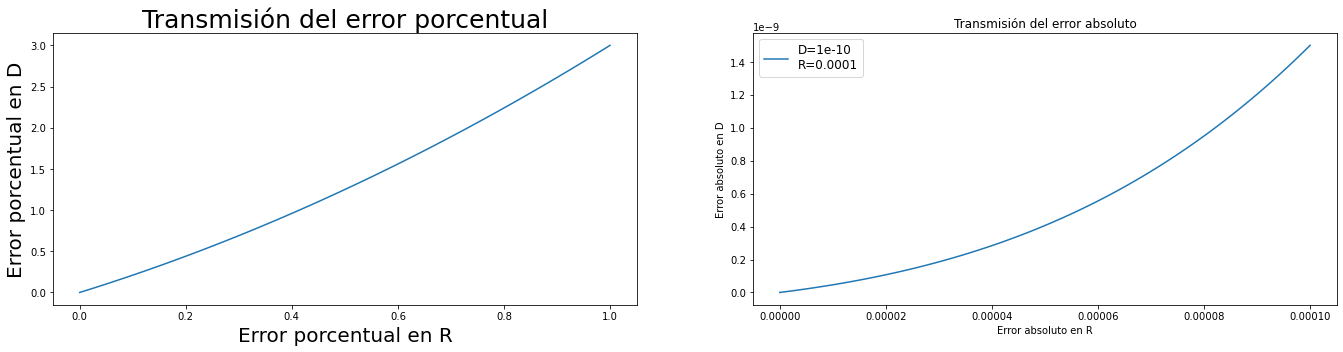

In [32]:
plt.figure(figsize=(23,5))
Reps = np.linspace(0,1,100)
Deps = (1+Reps)**2-1
plt.subplot(1,2,1)
plt.plot(Reps, Deps)
plt.xlabel("Error porcentual en R", fontsize =20)
plt.ylabel("Error porcentual en D", fontsize =20)
plt.title("Transmisión del error porcentual", fontsize =25)
plt.subplot(1,2,2)
plt.plot((Reps)*R1, D*(Deps+1)**2- np.ones_like(Deps)*D)
plt.xlabel("Error absoluto en R")
plt.ylabel("Error absoluto en D")
plt.title("Transmisión del error absoluto")
plt.legend([f"D={D}\nR={R1}"],fontsize="large")

plt.show()

**Perspectiva 3D**

Si consideramos $S_b$ en función de $D$ y $R$ entonces los funcionales definidos en (0) y (2) también podemos considerarlo en función de estas variables.

Tomaremos los parámetros reales igual que en el punto anterior y además consideraremos

$$T = 100.$$

Definimos las siguientes funciones auxiliares para graficar la superficie y la curva de nivel en $0$ del funcional definido en (2).

In [33]:
# Superficie
def funcauxDR(Dit, Rit, n, c_0, c_inf, t, f):
    FDR = np.zeros((Dit.size,Rit.size))
    for d in range(Dit.size):
        for r in range(Rit.size):
            g = func1(t, Dit[d], n, Rit[r], c_0, c_inf)
            FDR[d,r] = simps((g- f)**2,t)
    return FDR
# Curva de nivel
def funcauxDRl(Dit, Rit, n, c_0, c_inf, t, f):
    FDR = np.zeros(Dit.size)
    for m in range(Dit.size):
            g = func1(t, Dit[m], n, Rit[m], c_0, c_inf)
            FDR[m] = simps((g- f)**2,t)
    return FDR


la malla a utilizar será

In [34]:
auxlin = np.linspace(0.9,1.1,100)

Dl = auxlin*D
Rl = (auxlin**0.5)*R1

*Observación:* Se toma la malla de esta manera por la relación que tienen que cumplir las variables $R$ y $D$ para minimizar el funciónal
por lo que la superficie y la curva de nivel en $0$ quedan representadas por los siguientes arreglos, en efecto

In [35]:
print(f"La relación entre las variables reales es {D/R1**2} mientras que las relaciones de los arreglos son \n\n{Dl/Rl**2}.")

La relación entre las variables reales es 0.01 mientras que las relaciones de los arreglos son 

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01].


Por otro lado la superficie y la curva de nivel quedarán en los siguientes arreglos

In [36]:

fgrunaux = func1(np.linspace(0,100,1000), D, 16, R1, 0, Vc/(Vc+Vb))

tgrid1 = np.linspace(0, 100, 1000)

fgrunDRl = funcauxDRl(Dl,Rl, 16, 0, Vc/(Vc+Vb), tgrid1, fgrunaux)
fgrunDR2 = funcauxDR(Dl,Rl, 16, 0, Vc/(Vc+Vb), tgrid1, fgrunaux)
print(f"El arreglo \n\n{fgrunDRl}\n\n tiene entradas muy cercanas a 0 como se esperaba")

El arreglo 

[5.17809941e-41 2.76500454e-41 1.14478370e-40 1.00689256e-40
 1.97859416e-40 3.51191485e-41 2.73627722e-41 2.09278525e-40
 8.30937727e-41 6.70064736e-41 6.75810200e-41 2.53627822e-40
 1.20582925e-40 2.27951283e-40 3.02176992e-40 7.52117143e-41
 2.90864114e-41 1.02412895e-40 2.10427618e-40 3.54064217e-41
 1.10743818e-40 4.57482569e-41 1.21660200e-40 3.65555145e-41
 2.52800415e-41 1.96135776e-40 7.62710343e-41 4.94828085e-41
 4.86209889e-41 2.41849620e-40 1.07152903e-40 3.93564282e-41
 6.44210148e-41 9.48001556e-41 1.76260062e-40 6.41516962e-41
 1.24245658e-40 3.10973238e-41 2.18848314e-40 1.00976529e-40
 1.81430980e-40 7.13873899e-41 4.91955353e-41 1.29991122e-40
 2.20591404e-40 3.44727838e-41 3.93564282e-41 3.56218766e-41
 5.66646384e-41 5.20682673e-41 4.37373445e-41 9.42256092e-41
 1.75954834e-40 3.51191485e-41 5.97528253e-41 6.24819207e-41
 2.99284809e-40 1.44139327e-40 2.37790390e-40 2.11093434e-40
 2.05328519e-40 3.39700557e-41 4.53891654e-41 1.41194777e-40
 2.37540522

Finalmente se grafica

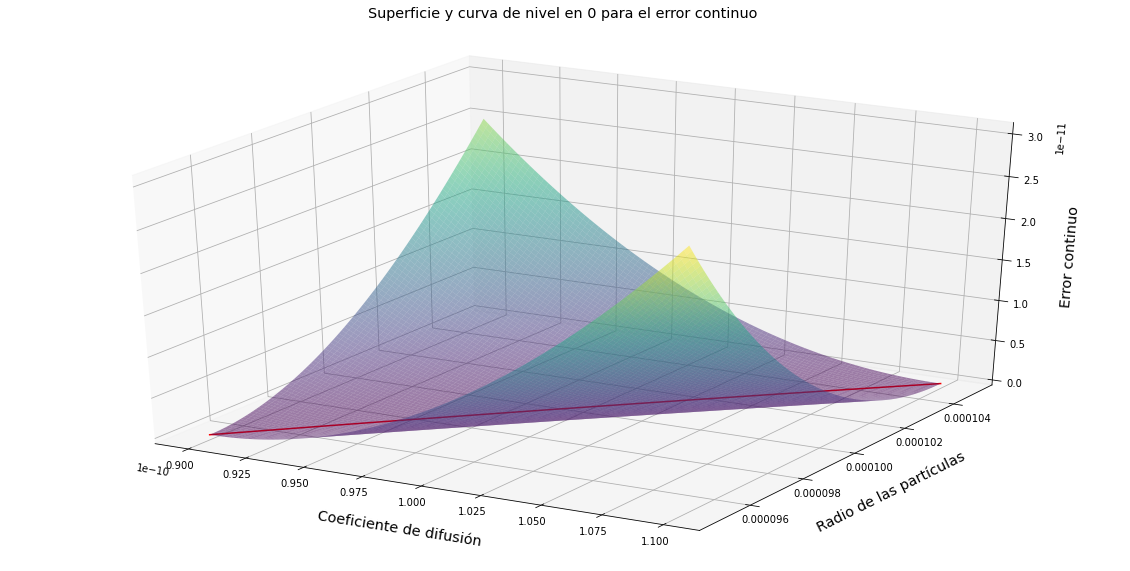

In [37]:
XD2, YR2 = np.meshgrid(Dl,Rl)

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

xLabel = ax.set_xlabel('\nCoeficiente de difusión', linespacing=3.2, fontsize="x-large")
yLabel = ax.set_ylabel('\nRadio de las partículas', linespacing=3.1, fontsize="x-large")
zLabel = ax.set_zlabel('\nError continuo', linespacing=3.4, fontsize="x-large")
ax.plot(Dl, Rl, fgrunDRl,"r")
ax.plot_surface(XD2, YR2, fgrunDR2,cmap='viridis',rstride=1, cstride=1, alpha=0.5)
Title = ax.set_title("Superficie y curva de nivel en 0 para el error continuo \n ", linespacing=3.4, fontsize="x-large")

plt.show()

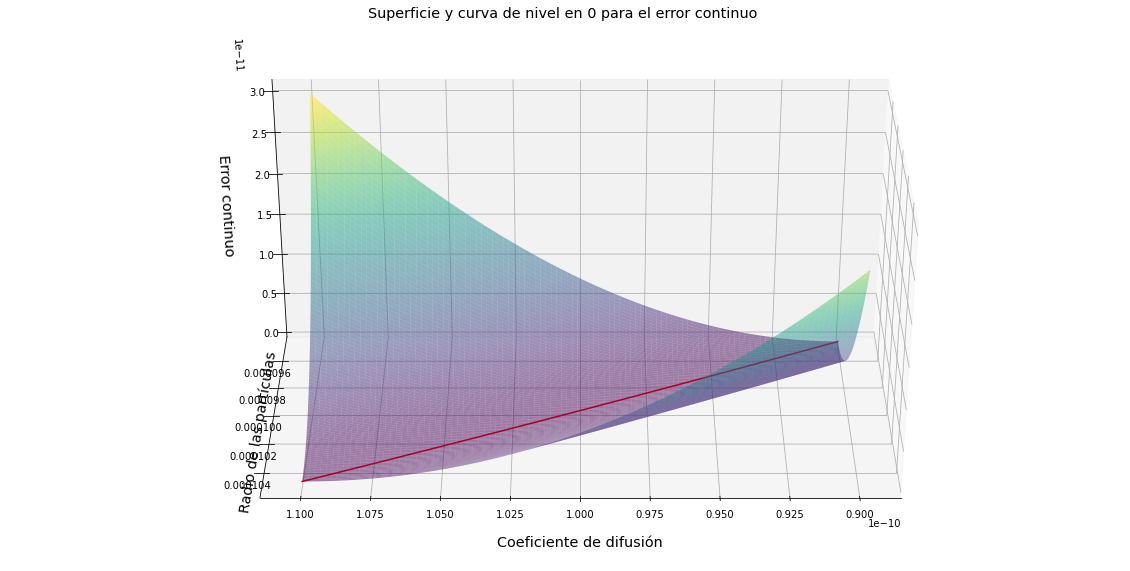

In [38]:
ax.view_init(30, 90)
fig